In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="darkgrid")

from plot_utils import *

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
results_df = results_df = pd.read_pickle("models/results_df.p")

In [3]:
df_gmf = GMF_df(results_df)
idxmax = [df_gmf[df_gmf.dl_frame == "keras"].best_hr.idxmax(), 
          df_gmf[df_gmf.dl_frame == "pytorch"].best_hr.idxmax(),
          df_gmf[df_gmf.dl_frame == "gluon"].best_hr.idxmax()]
df_gmf.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,n_emb
0,0.655795,0.37442,22,gluon,8
1,0.681291,0.397792,20,gluon,16
2,0.687417,0.408483,19,gluon,32
3,0.917219,0.632879,29,gluon,64
4,0.649834,0.370375,16,keras,8
5,0.686589,0.407822,25,keras,16
6,0.700166,0.420537,28,keras,32
7,0.690894,0.409264,6,keras,64
8,0.654305,0.375053,26,pytorch,8
9,0.681457,0.400793,22,pytorch,16


In [4]:
df_mlp = MLP_df(results_df)
idxmax = [df_mlp[df_mlp.dl_frame == "keras"].best_hr.idxmax(), 
          df_mlp[df_mlp.dl_frame == "pytorch"].best_hr.idxmax(),
          df_mlp[df_mlp.dl_frame == "gluon"].best_hr.idxmax()]
df_mlp.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,n_emb,with_dropout
0,0.459603,0.251677,7,gluon,16,wodp
1,0.936093,0.578107,14,gluon,32,wodp
2,0.781126,0.542325,3,gluon,64,wdp
3,0.702152,0.514179,40,gluon,128,wdp
4,0.657616,0.382151,26,keras,16,wodp
5,0.683609,0.400878,25,keras,32,wodp
6,0.686755,0.401642,11,keras,64,wodp
7,0.703311,0.414863,32,keras,128,wdp
8,0.658775,0.38508,28,pytorch,16,wodp
9,0.674669,0.386828,40,pytorch,32,wdp


In [5]:
df_neumf = NeuMF_df(results_df)
idxmax = [df_neumf[df_neumf.dl_frame == "keras"].best_hr.idxmax(), 
          df_neumf[df_neumf.dl_frame == "pytorch"].best_hr.idxmax(),
          df_neumf[df_neumf.dl_frame == "gluon"].best_hr.idxmax()]
df_neumf.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,with_pretrained,last_layer,optimizer
59,0.690066,0.410179,5,keras,wopret,trainable,sgd
60,0.710265,0.426209,3,keras,wpret,trainable,sgd
61,0.71043,0.426734,2,keras,wpret,frozen,sgd
62,0.980298,0.638231,26,pytorch,wopret,trainable,sgd
63,0.651987,0.524642,4,pytorch,wpret,trainable,sgd
64,0.651325,0.527078,5,pytorch,wpret,frozen,sgd
65,0.674338,0.391853,13,gluon,wopret,trainable,sgd
66,0.910099,0.575816,1,gluon,wpret,trainable,sgd
67,0.910099,0.57581,1,gluon,wpret,frozen,sgd
68,0.700828,0.421011,2,keras,wpret,trainable,adam


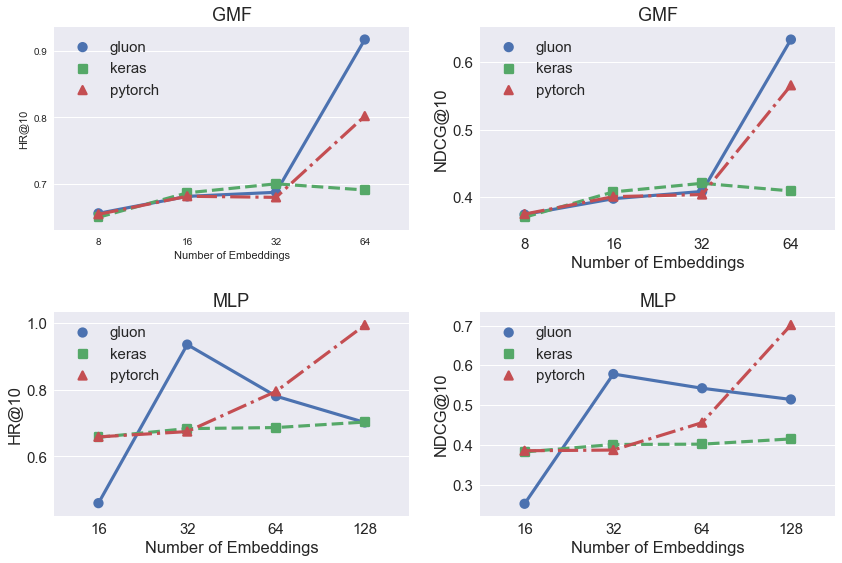

In [6]:
plot_metrics(df_gmf, df_mlp)

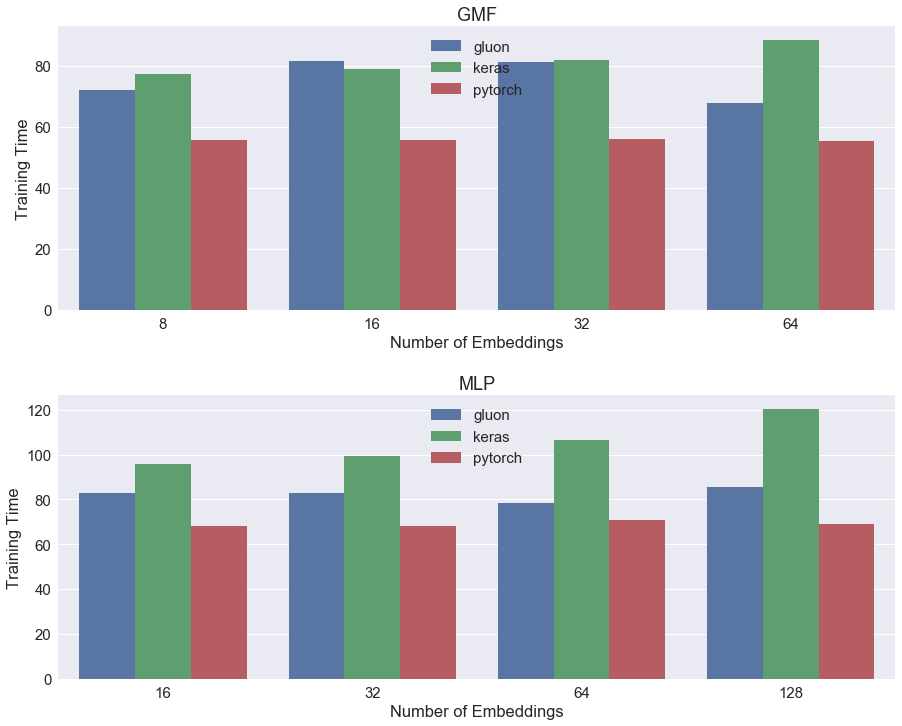

In [7]:
plot_train_time(results_df)